In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [155]:
#!pip install torchoptics

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import random

import torch
import torch.nn as nn
from torch.nn import Parameter
#import torchoptics
#from torchoptics import System
#from torchoptics.elements import PhaseModulator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

In [3]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

Using Device: cuda
The current device number is 0
GPU is Tesla P100-PCIE-16GB


### Global Functions

In [4]:
# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

#def speckle_pattern():

def random_pi():
    """Generates a random number (3dp) between -pi and pi."""
    return random.randrange(-3141,3141,1)/1000

def random_phase_grid(size, reproduce=False, seed=0):
    """Generates a random square plane of specified size with each pixel having a random phase change attached to it.
    Ranges from -pi to pi. Can reproduce the same matrix if 'reproduce' is set to True."""
    if reproduce == 1:
        torch.manual_seed(seed)
        return 2 * np.pi * torch.rand(size,size) - np.pi
    elif reproduce == 0:
        return 2 * np.pi * torch.rand(size,size) - np.pi
    else:
        print(f"Invalid reproducability value given. Accepts either 'True' or 'False'. What was given: {reproduce}.")

def gaussian(shape, mean, std):
    x, y = np.meshgrid(np.linspace(-1, 1, shape), np.linspace(-1, 1, shape))
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-((d - mean)**2 / (2.0 * std**2)))
    return gaussian

def gaussian_torch(shape, mean, std):
    x, y = np.meshgrid(np.linspace(-1, 1, shape), np.linspace(-1, 1, shape))
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-((d - mean)**2 / (2.0 * std**2)))
    gaussian = torch.from_numpy(gaussian)
    return gaussian
    
def loss_function(output_fields, target_fields):
    similarity = 1
    for (n, output_field) in enumerate(output_fields):
        inner_product = (output_field * torch.conj(target_fields[n])).abs()
        similarity = similarity * inner_product.sum()
    return (1-similarity)

# Configure TorchOptics Default Properties
#torchoptics.set_default_spacing(10e-6) # Spacing between grid points
#torchoptics.set_default_wavelength(700e-9) # Wavelength of monochromatic field

In [5]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    wl = 700e-9 #[m]
    k = torch.tensor(2*np.pi/wl) #[1/m]
    k_x = 1235678
    k_y = 3457437
    k_z = (torch.abs(k)**2 - k_x**2 - k_y**2)**0.5 #[1/m]
    
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the 
        fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Normalised Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()
        
    def propagate_along_z(self, z):
        """Propagates an initial electric field over a specified distance of free space. Assuming the direction of travel
        is along the z axis."""
        # Assuming each pixel is an individual plane wave:
            
        # Fourier transform a vectorised input electric field into momentum space.
        initial_p_field = torch.fft.fft(self)
        # Add on any extra phase the field accumulates.
        propagated_p_field = initial_p_field * torch.exp(1j*self.k*z)
        # Inverse fourier transform back into real space
        propagated_r_field = torch.fft.ifft(propagated_p_field)
            
        return propagated_r_field

    def free_space_propagate(self, z):
        """Propagates a 2D field along one axis by a distance z. 
        Vectorises the input field to do this, but still returns a 2D field"""
        input_field_torch = self.type(torch.cfloat)
        # Vectorise the input field
        in_torch_vec = vectorise(input_field_torch)
        # FFT Input Field
        in_torch_fft = torch.fft.fft(in_torch_vec)

        # Construct a diagonal matrix for the phase accumulated to be added on
        im = torch.full((100*100,1),1j)
        phase_accumulated = torch.diag(torch.exp(im.flatten()*z*self.k))

        # Multiply the vector by matrix
        out_torch_fft = phase_accumulated @ in_torch_fft
        # IFFT Output Field
        out_torch_vec = torch.fft.ifft(out_torch_fft)

        # Restore the output vector to a square matrix
        return unvectorise(out_torch_vec, 100)

In [20]:
pix_size = 1e-5 #[m]
grid_size = 100 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.linspace(-50,50,grid_size)
Ny = np.linspace(-50,50,grid_size)
X,Y = np.meshgrid(Nx,Ny)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-50,50,1), np.arange(0,101,1)):
    for x,j in zip(np.arange(-50,50,1), np.arange(0,101,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

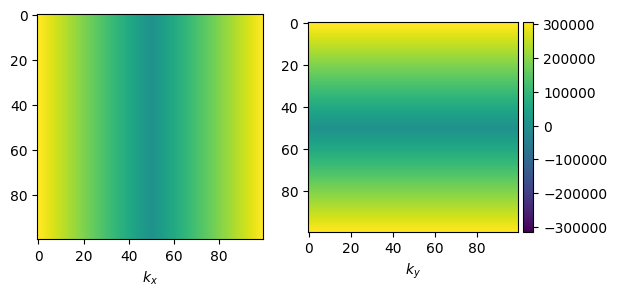

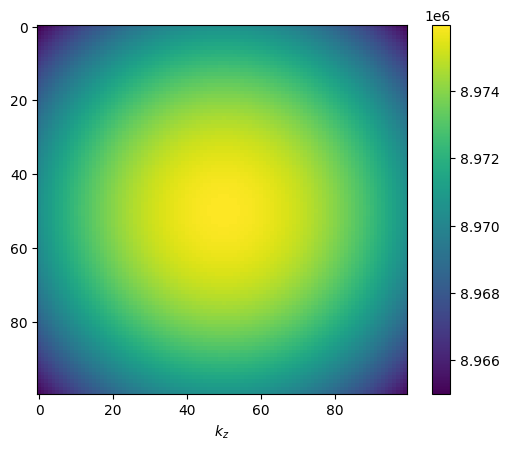

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2)
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)
fig, ax = plt.subplots(1,1)
im1 = ax.imshow(Kz)
ax.set_xlabel("$k_z$")
fig.colorbar(im1)

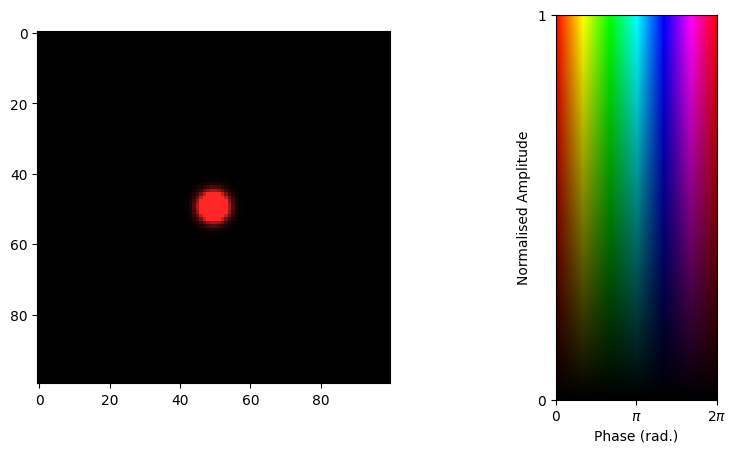

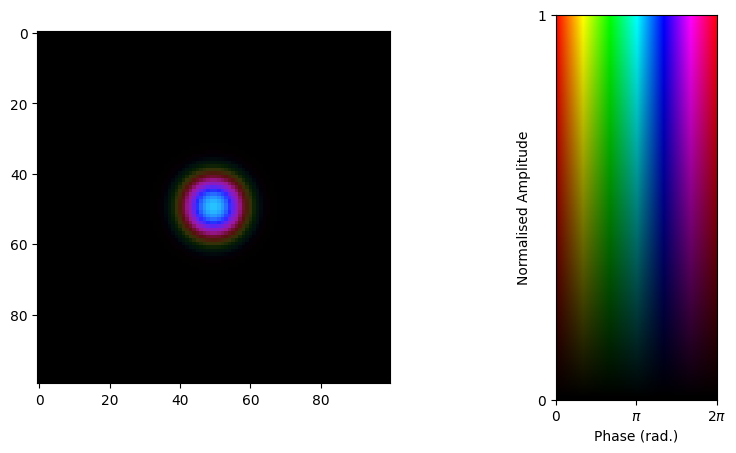

In [26]:
input_field = Field(gaussian_torch(100, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()

output_field = prop(input_field, Kz, 0.01)
output_field.visualise()

In [36]:
pix_size = 1e-5 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.linspace(-250,250,grid_size)
Ny = np.linspace(-250,250,grid_size)
X,Y = np.meshgrid(Nx,Ny)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-250,250,1), np.arange(0,501,1)):
    for x,j in zip(np.arange(-250,250,1), np.arange(0,501,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

#print(Kx)

In [7]:
np.linspace(0,10,11)
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

torch.Size([500, 500])


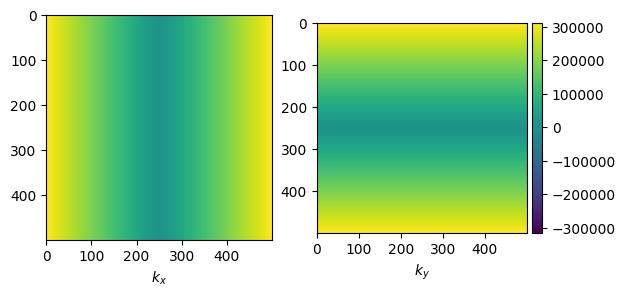

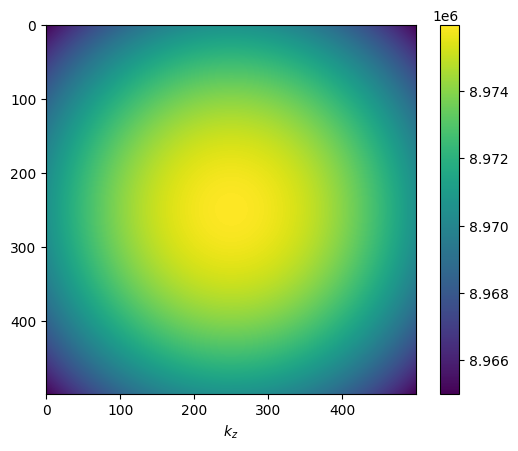

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2)
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)
fig, ax = plt.subplots(1,1)
im1 = ax.imshow(Kz)
ax.set_xlabel("$k_z$")
fig.colorbar(im1)
print(Kz.shape)

In [39]:
# Make FFT functions
def fft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete forward fourier transform."""
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(field)))

def ifft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete inverse fourier transform."""
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(field)))

In [40]:
# Test fft functions to see if they return the same tensor after use
test = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
ifft2(fft2(test))
# Returned the original tensor!

tensor([[1.+0.j, 2.+0.j, 3.+0.j],
        [4.+0.j, 5.+0.j, 6.+0.j],
        [7.+0.j, 8.+0.j, 9.+0.j]])

In [41]:
# Make a propagation function using these fft2 functions
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in)
    field_out_ft = field_in_ft * torch.exp(1j*kz*distance)
    field_out = ifft2(field_out_ft)
    return field_out

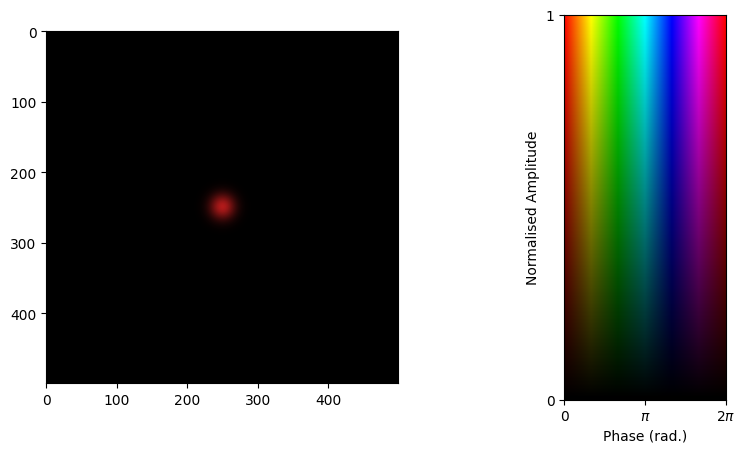

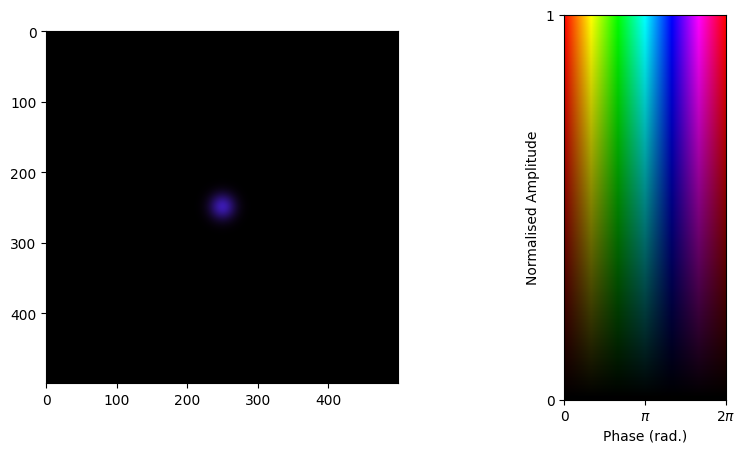

In [42]:
# Test the prop function
input_field = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()

output_field = prop(input_field, Kz, 0.01)
output_field.visualise()

# Output gaussian is defocused and had altering phase as expected!! Note: Normalisation also seems to be preserved here.

In [43]:
# Make the tilt phase mask function
def tilt2d(field_in: torch.Tensor, X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Adds tilted phase to a 2D complex field."""
    tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(alpha)) + Y*torch.sin(torch.deg2rad(beta)))
    field_out = field_in * torch.exp(1j*tilt_phase)
    #field_out = torch.abs(field_in) * torch.exp(1j*(tilt_phase+torch.angle(field_in)))
    return field_out

def tilt_phase_mask(X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Makes the tilt phase mask field, useful for plotting."""
    return torch.exp(1j*(-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(alpha)) + Y*torch.sin(torch.deg2rad(beta))))

In [49]:
torch.deg2rad(torch.tensor(90))

tensor(1.5708)

In [52]:
Nx = np.linspace(-500,500,grid_size)
Ny = np.linspace(-500,500,grid_size)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)
alpha = torch.tensor(0.005)
beta = torch.tensor(0.005)

t1 = Field(torch.ones(1000,1000))
tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(alpha)) + Y*torch.sin(torch.deg2rad(beta)))
tilt_mask = t1 * torch.exp(1j*tilt_phase)
tilt_mask.visualise()

RuntimeError: The size of tensor a (1000) must match the size of tensor b (500) at non-singleton dimension 1

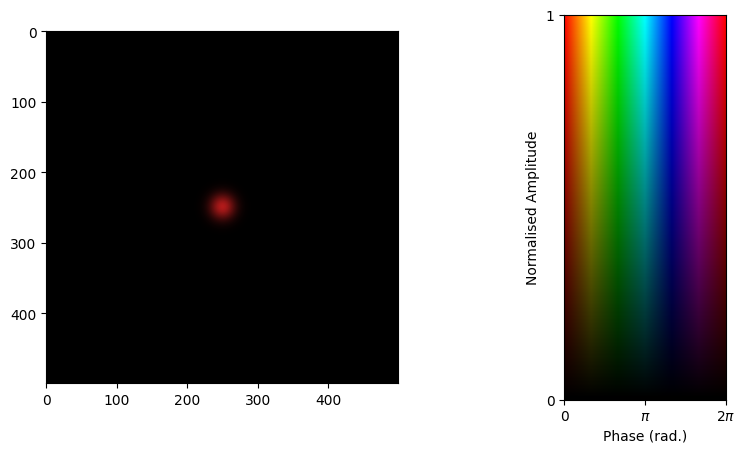

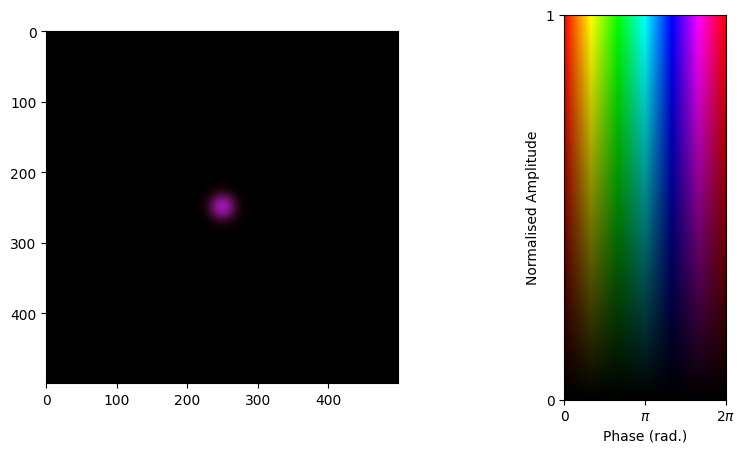

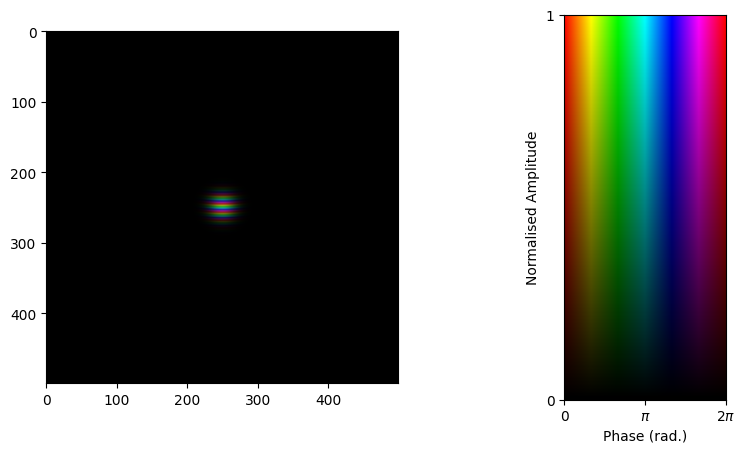

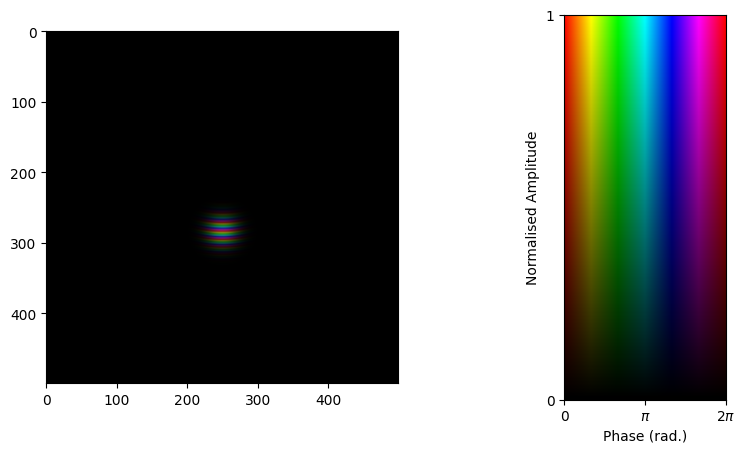

In [16]:
# Propagate a gaussian beam to the phase mask and further (Create data for model)
input_field = Field(gaussian_torch(500, 0, 0.05)).normalise().type(torch.cdouble)
input_field.visualise()
field_before_mask = prop(input_field, Kz, 0.04)
field_before_mask.visualise()
field_after_mask = tilt2d(field_before_mask,X,Y,700e-9,alpha=alpha, beta=beta)
field_after_mask.visualise()
output_field = prop(field_after_mask,Kz,0.06)
output_field.visualise()

In [ ]:
# CODE IS OUTDATED, HERE FOR A RECORD OF WORK

# Check the propagation agrees if the field is vectorised
# Take the input field:
input_field_torch = Field(gaussian_torch(100, 0, 0.1)).normalise()
input_field_torch = input_field_torch.type(torch.cdouble)
#input_field_torch.visualise()

# Vectorise the input field
in_torch_vec = input_field_torch.flatten()
# FFT Input Field
in_torch_fft = torch.fft.fft(in_torch_vec)

# Construct a diagonal matrix for the phase accumulated to be added on
z = 0.0001
k_z = (2*np.pi)/700e-9
im = torch.full((100*100,1),1j)
im.flatten().shape
Kz.flatten().shape
#phase_accumulated = torch.diag(torch.exp(im.flatten()*z*k_z))
phase_accumulated = torch.diag(torch.exp(1j*z*Kz.flatten()))

# Multiply the vector by matrix
out_torch_fft = phase_accumulated @ in_torch_fft
# IFFT Output Field
out_torch_vec = torch.fft.ifft(out_torch_fft)

# Restore the output vector to a square matrix
output_torch = unvectorise(out_torch_vec, 100)

# Plot the output vector
#output_torch.normalise().visualise()

# There is agreement between the methods!!!

In [ ]:
# Phase Masks
def speckle_phase_mask(grid_size, diag=False, seed=0):
    """Passes an input field through a phase mask with a random pixel pattern on it."""
    # Generate the random pixel pattern
    phase_mask = random_phase_grid(grid_size, True, seed)
    if diag == True:
        # Convert the phase_mask to a diagonal matrix
        return torch.diag(torch.exp(1j*phase_mask.flatten()))
    else:
        return phase_mask
        
def apply_speckle_mask(grid_size, input_field, seed=0):
    """Applies the phase changes from a diagonal phase mask to a vectorised input field."""
    # Pass the input_field through the phase mask (input should be vectorised)
    output_vec = speckle_phase_mask(grid_size=grid_size, diag=True, seed=seed) @ vectorise(input_field)
    return unvectorise(output_vec, 100)

In [ ]:
# Input field
input_gaussian = Field(gaussian_torch(100, 0, 0.2)).normalise()
input_gaussian.cpu().visualise()

# Propagate distance z1 = 0.04m
field_at_z1 = input_gaussian.free_space_propagate(0.04)
field_at_z1.cpu().visualise()
# Apply phase mask
field_after_mask = apply_speckle_mask(100, field_at_z1)
field_after_mask.cpu().visualise()
# Propagate distance z2 = 0.06m
field_at_z2 = field_after_mask.free_space_propagate(0.06)
field_at_z2.cpu().visualise()

In [ ]:
class AxialModel(nn.Module):
    """Model for finding the axial positioning of a speckle phase mask."""
    def __init__(self, grid_size):
        super(AxialModel, self).__init__()
        self.grid_size = grid_size

        # Parameter(s)
        self.z1 = nn.Parameter(torch.tensor([0.01], dtype=torch.cfloat))

    def forward(self, input_field, z):
        """Forward model for the system. Input a normalised 'field' class field."""
        field_at_z1 = input_gaussian.free_space_propagate(self.z1)
        field_after_mask = apply_speckle_mask(self.grid_size, field_at_z1)
        field_at_z2 = field_after_mask.free_space_propagate(z-self.z1)
        return field_at_z2.normalise()

In [ ]:
def mseloss(output, target):
    return torch.sum((target.abs() - output.abs())**2)

In [ ]:
model = AxialModel(100)#.to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-4)
#loss_func = mseloss() #nn.MSELoss()
input_field = input_gaussian#.to(device)
target = field_at_z2#.to(device)
losses = [] # Create a list to graph later

epochs = 100
for epoch in range(epochs):
    optimiser.zero_grad()
    output = model(input_field, 0.1)
    loss = mseloss(output, target)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

In [ ]:
model = AxialModel(100)#.to(device)
input_field = input_gaussian
target = field_at_z2
loss = []
for i in np.arange(0,0.1,0.005):
    #torch.cuda.empty_cache()
    output = model(input_field, 0.1)
    loss.append(mseloss(output,target))

    if i % 0.01 == 0:
        print(i)
    
#print(torch.cuda.memory_summary(device=None, abbreviated=False))
    

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
y = loss
x = np.arange(0,0.1,0.005)
axs.plot(x,y)

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
torch.cuda.empty_cache()